<a href="https://colab.research.google.com/github/BitWeavre/Deep-Learning-Project-1/blob/main/Project_Image_Classifier_Project_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 

<img src='https://github.com/udacity/pytorch_challenge/blob/master/assets/Flowers.png?raw=1' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of your code. As you work through this notebook and find you need to import a package, make sure to add the import up here.

In [ ]:
!pip --no-cache-dir install tfds-nightly

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.4 MB 5.0 MB/s 
     |████████████████████████████████| 98 kB 49.0 MB/s 


In [ ]:
# The new version of dataset is only available in the tfds-nightly package.
%pip --no-cache-dir install tensorflow-datasets --user
# DON'T MISS TO RESTART THE KERNEL

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Import Resources

In [ ]:
# TODO: Make all necessary imports.
import warnings
warnings.filterwarnings('ignore')

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import time
import numpy as np
import glob
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
tfds.disable_progress_bar()
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.ops.gen_nn_ops import top_k

In [ ]:
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

In [ ]:
print('Using:')
print('\t\u2022 TensorFlow version:', tf.__version__)
print('\t\u2022 tf.keras version:', tf.keras.__version__)
print('\t\u2022 Running on GPU' if tf.test.is_gpu_available() else '\t\u2022 GPU device not found. Running on CPU')

Using:
	• TensorFlow version: 2.8.2
	• tf.keras version: 2.8.0
	• Running on GPU


In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


## Load the Dataset

Here you'll use `tensorflow_datasets` to load the [Oxford Flowers 102 dataset](https://www.tensorflow.org/datasets/catalog/oxford_flowers102). This dataset has 3 splits: `'train'`, `'test'`, and `'validation'`.  You'll also need to make sure the training data is normalized and resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet, but you'll still need to normalize and resize the images to the appropriate size.

In [ ]:
# Download data to default local directory "~/tensorflow_datasets"
!python -m tensorflow_datasets.scripts.download_and_prepare --register_checksums=True --datasets=oxford_flowers102

# TODO: We load the dataset with TensorFlow Datasets using tfds.load().

dataset, dataset_info = tfds.load('oxford_flowers102', with_info=True, as_supervised=True)
dataset_info

# We create a training set, a validation set and a test set.
training_set, validation_set, test_set = dataset['train'],dataset['validation'],dataset['test']

usage: download_and_prepare.py build [-h] [--helpfull]
                                     [--module_import MODULE_IMPORT]
                                     [--builder_config_id BUILDER_CONFIG_ID]
                                     [--datasets DATASETS_KEYWORD [DATASETS_KEYWORD ...]]
                                     [--overwrite]
                                     [--max_examples_per_split [MAX_EXAMPLES_PER_SPLIT]]
                                     [--data_dir DATA_DIR]
                                     [--download_dir DOWNLOAD_DIR]
                                     [--extract_dir EXTRACT_DIR]
                                     [--manual_dir MANUAL_DIR]
                                     [--add_name_to_manual_dir]
                                     [--config CONFIG]
                                     [--config_idx CONFIG_IDX]
                                     [--imports IMPORTS]
                                     [--register_checksums]
                

## Explore the Dataset

In [ ]:
# Display the dataset_info
dataset_info

tfds.core.DatasetInfo(
    name='oxford_flowers102',
    full_name='oxford_flowers102/2.1.1',
    description="""
    The Oxford Flowers 102 dataset is a consistent of 102 flower categories commonly occurring
    in the United Kingdom. Each class consists of between 40 and 258 images. The images have
    large scale, pose and light variations. In addition, there are categories that have large
    variations within the category and several very similar categories.
    
    The dataset is divided into a training set, a validation set and a test set.
    The training set and validation set each consist of 10 images per class (totalling 1020 images each).
    The test set consists of the remaining 6149 images (minimum 20 per class).
    
    Note: The dataset by default comes with a test size larger than the train
    size. For more info see this [issue](https://github.com/tensorflow/datasets/issues/3022).
    """,
    homepage='https://www.robots.ox.ac.uk/~vgg/data/flowers/102/',
    data

In [ ]:
# TODO: Get the number of examples in each set from the dataset info.
total_examples = dataset_info.splits['train'].num_examples + dataset_info.splits['test'].num_examples

num_training_examples = dataset_info.splits['train'].num_examples
num_validation_examples = dataset_info.splits['validation'].num_examples
num_test_examples = dataset_info.splits['test'].num_examples

print('The entire dataset contains {:,} images\n'.format(dataset_info.splits.total_num_examples))

print('There are {:,} images in the training set'.format(num_training_examples))
print('There are {:,} images in the validation set'.format(num_validation_examples))
print('There are {:,} images in the test set'.format(num_test_examples))


# TODO: Get the number of classes in the dataset from the dataset info.
num_classes = dataset_info.features['label'].num_classes
print('There are {:,} classes in the dataset'.format(num_classes))

shape_images = dataset_info.features['image'].shape
print('The images in our dataset have shape:', shape_images)

The entire dataset contains 8,189 images

There are 1,020 images in the training set
There are 1,020 images in the validation set
There are 6,149 images in the test set
There are 102 classes in the dataset
The images in our dataset have shape: (None, None, 3)


In [ ]:
# TODO: Print the shape and corresponding label of 3 images in the training set.
for image, label in training_set.take(3):
    print('This image in the training set has:\n\u2022 shape:', image.shape, '\n\u2022 label:', label)

This image in the training set has:
• shape: (500, 667, 3) 
• label: tf.Tensor(72, shape=(), dtype=int64)
This image in the training set has:
• shape: (500, 666, 3) 
• label: tf.Tensor(84, shape=(), dtype=int64)
This image in the training set has:
• shape: (670, 500, 3) 
• label: tf.Tensor(70, shape=(), dtype=int64)


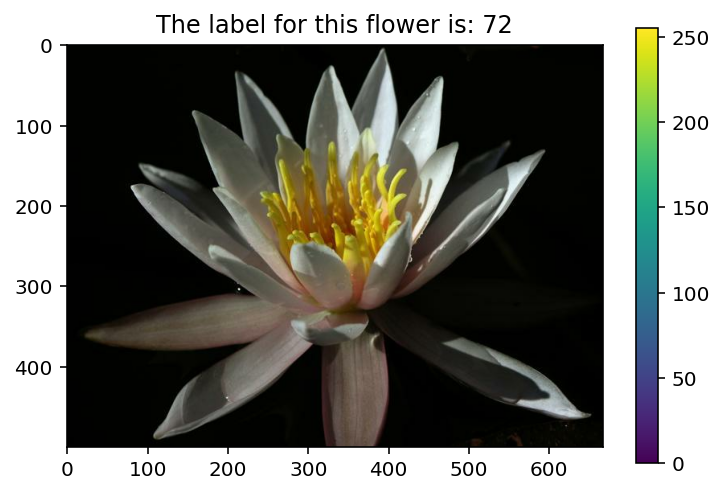

In [ ]:
# TODO: Plot 1 image from the training set. Set the title 
# of the plot to the corresponding image label. 
for image, label in training_set.take(1):
    image = image.numpy()
    label = label.numpy()

plt.imshow(image, cmap= None)
plt.title('The label for this flower is: {}'.format(label))
plt.colorbar()
plt.show()


### Label Mapping

You'll also need to load in a mapping from label to category name. You can find this in the file `label_map.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/3.7/library/json.html). This will give you a dictionary mapping the integer coded labels to the actual names of the flowers.

In [ ]:
import json

In [ ]:
# Since we are working on Google Colab, we access our data on Google drive 

#with open('label_map.json', 'r') as f:
with open('/content/drive/My Drive/Colab Notebooks/p2_image_classifier/label_map.json', 'r') as f:
    class_names = json.load(f)

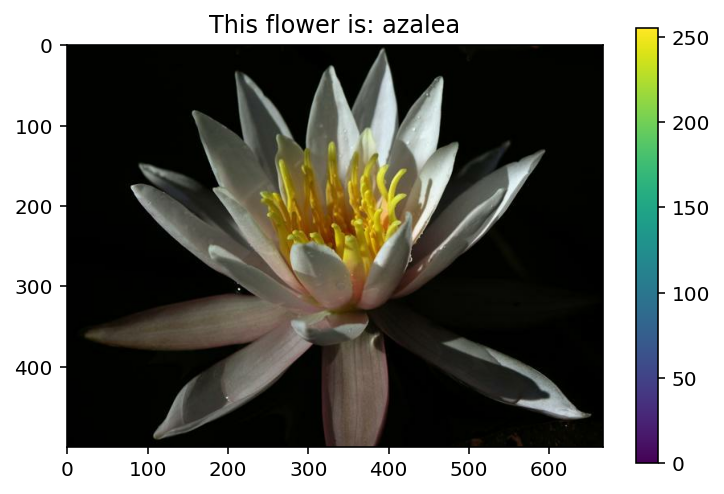

In [ ]:
# TODO: Plot 1 image from the training set. Set the title 
# of the plot to the corresponding class name. 

for image, label in training_set.take(1):
    image = image.numpy()
    label = label.numpy()

plt.imshow(image, cmap = None)
plt.title('This flower is: {}'.format(class_names[str(label)]))
plt.colorbar()
plt.show()


## Create Pipeline

In [ ]:
# TODO: Create a pipeline for each set.
batch_size = 2
image_size = 224
shuffle_size = dataset_info.splits.total_num_examples//4


def normalize(image, label):
    image = tf.cast(image, tf.float32)
    image /= 255
    image = tf.image.resize_with_crop_or_pad(image, target_height = image_size, target_width = image_size)
    return image, label

training_batches = training_set.cache().shuffle(num_training_examples).padded_batch(batch_size).map(normalize).prefetch(1)
validation_batches = validation_set.cache().map(normalize).padded_batch(batch_size).prefetch(1)
testing_batches = test_set.cache().padded_batch(batch_size).map(normalize).prefetch(1)


In [ ]:
training_batches

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [ ]:
validation_batches

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [ ]:
testing_batches

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

# Build and Train the Classifier

Now that the data is ready, it's time to build and train the classifier. You should use the MobileNet pre-trained model from TensorFlow Hub to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. If you want to talk through it with someone, chat with your fellow students! 

Refer to the rubric for guidance on successfully completing this section. Things you'll need to do:

* Load the MobileNet pre-trained network from TensorFlow Hub.
* Define a new, untrained feed-forward network as a classifier.
* Train the classifier.
* Plot the loss and accuracy values achieved during training for the training and validation set.
* Save your trained model as a Keras model. 

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right.

**Note for Workspace users:** One important tip if you're using the workspace to run your code: To avoid having your workspace disconnect during the long-running tasks in this notebook, please read in the earlier page in this lesson called Intro to GPU Workspaces about Keeping Your Session Active. You'll want to include code from the workspace_utils.py module. Also, If your model is over 1 GB when saved as a checkpoint, there might be issues with saving backups in your workspace. If your saved checkpoint is larger than 1 GB (you can open a terminal and check with `ls -lh`), you should reduce the size of your hidden layers and train again.

In [ ]:
# TODO: Build and train your network.

# First, we do transfer learning
# We use the MobileNet pre-trained model from TensorFlow Hub to get the image features
# We create the feature_extractor part of our pre-trained model. It will be responsible for extracting our 
# image's features
URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

feature_extractor = hub.KerasLayer(URL, input_shape = (image_size, image_size,3))

# We freeze the weights and biases of our pre-trained model so that we don't modify them during training.
feature_extractor.trainable = False

In [ ]:
# We build the model
# We now create a tf.keras Sequential model with our feature_extractor and an output layer with the number of units being the number of classes

model = tf.keras.Sequential([
        feature_extractor,
        tf.keras.layers.Dense(num_classes, activation = 'softmax')
])


# We also enhance our code to incorporate distributed training with multiple GPUs.
print('Is there a GPU Available:', tf.test.is_gpu_available())

model.summary()


Is there a GPU Available: True
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 102)               130662    
                                                                 
Total params: 2,388,646
Trainable params: 130,662
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:
# We compile the model using the Adam optimizer, and fine tune with a lower leraning rate and higher epsilon

model.compile(optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.0001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-09,
    amsgrad=False,
    name="Adam",
),
              
              loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy'])

In [ ]:
# We add a callback to stop training when there is no improvement in the validation loss 
# after 10 consecutive epochs

early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', 
                                                  patience = 20, 
                                                  verbose = True,
                                                  restore_best_weights = True)

# We save the Model with the lowest validation loss
save_best = tf.keras.callbacks.ModelCheckpoint('./best_model.h5',
                                               monitor = 'val_loss',
                                               save_best_only = True)


In [ ]:
# We stop training when there is no improvement in the validation loss for 50 epochs

EPOCHS = 100

history = model.fit(training_batches,
                epochs = EPOCHS, 
                validation_data = validation_batches,
                callbacks = [early_stopping, save_best])

Epoch 1/100
510/510 [==============================] - 29s 27ms/step - loss: 4.6236 - accuracy: 0.0451 - val_loss: 3.8048 - val_accuracy: 0.1510
Epoch 2/100
510/510 [==============================] - 11s 21ms/step - loss: 3.2918 - accuracy: 0.2882 - val_loss: 3.0903 - val_accuracy: 0.3490
Epoch 3/100
510/510 [==============================] - 11s 21ms/step - loss: 2.5206 - accuracy: 0.5294 - val_loss: 2.5856 - val_accuracy: 0.4931
Epoch 4/100
510/510 [==============================] - 11s 21ms/step - loss: 1.9487 - accuracy: 0.6931 - val_loss: 2.2289 - val_accuracy: 0.5637
Epoch 5/100
510/510 [==============================] - 11s 21ms/step - loss: 1.5822 - accuracy: 0.7873 - val_loss: 1.9741 - val_accuracy: 0.6098
Epoch 6/100
510/510 [==============================] - 11s 21ms/step - loss: 1.2677 - accuracy: 0.8353 - val_loss: 1.7817 - val_accuracy: 0.6422
Epoch 7/100
510/510 [==============================] - 11s 21ms/step - loss: 1.0572 - accuracy: 0.8539 - val_loss: 1.6446 - val_ac

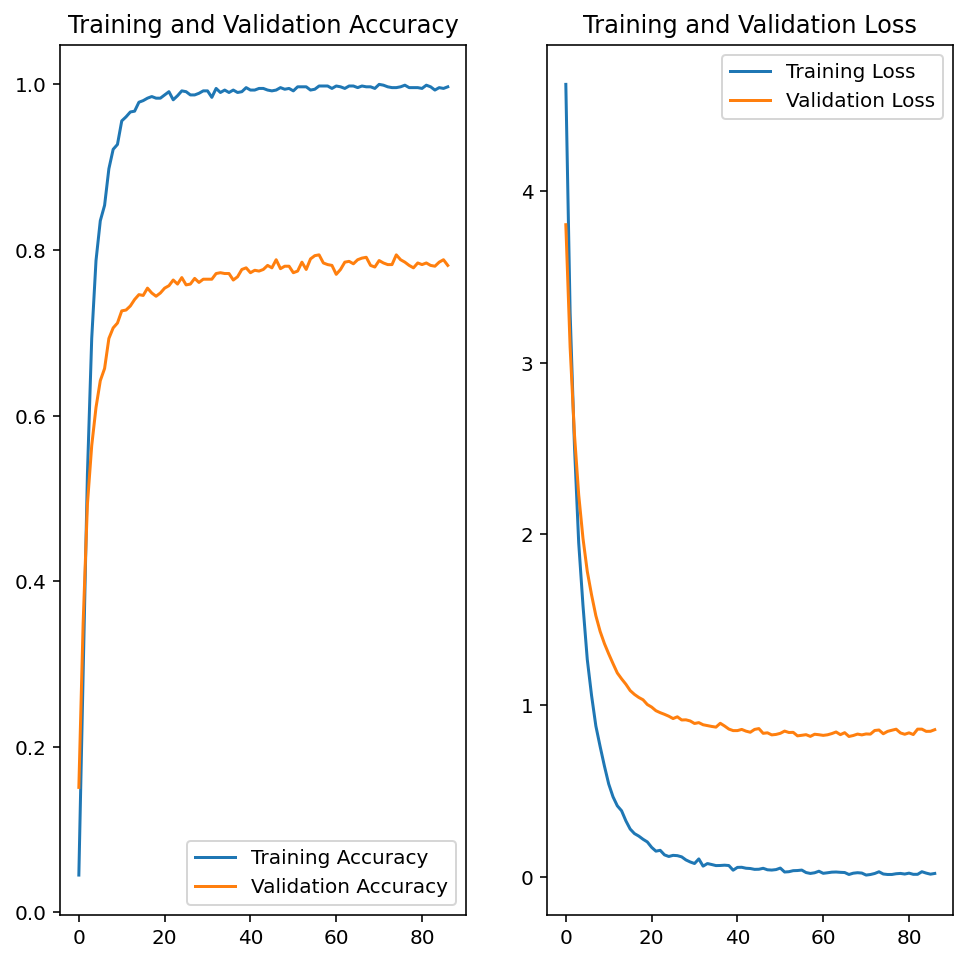

In [ ]:
# TODO: Plot the loss and accuracy values achieved during training for the training and validation set.


training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

training_loss = history.history['loss']
validation_loss = history.history['val_loss']

epochs_range=range(len(training_accuracy))

plt.figure(figsize = (8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, training_accuracy, label = 'Training Accuracy')
plt.plot(epochs_range, validation_accuracy, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, training_loss, label = 'Training Loss')
plt.plot(epochs_range, validation_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
# We print the model's performance using the training set and validation set
loss, accuracy = model.evaluate(training_batches)
    
print('\nLoss on TRAINING set: {:,.3f}'.format(loss))
print('Accuracy on TRAINING set: {:.3%}'.format(accuracy))


loss, accuracy = model.evaluate(validation_batches)
    
print('\nLoss on VALIDATION set: {:,.3f}'.format(loss))
print('Accuracy on VALIDATION set: {:.3%}'.format(accuracy))

510/510 [==============================] - 6s 11ms/step - loss: 0.0105 - accuracy: 0.9990

Loss on TRAINING set: 0.011
Accuracy on TRAINING set: 99.902%
510/510 [==============================] - 5s 10ms/step - loss: 0.8182 - accuracy: 0.7902

Loss on VALIDATION set: 0.818
Accuracy on VALIDATION set: 79.020%


## Testing your Network

It's good practice to test your trained network on test data, images the network has never seen either in training or validation. This will give you a good estimate for the model's performance on completely new images. You should be able to reach around 70% accuracy on the test set if the model has been trained well.

In [ ]:
# TODO: Print the loss and accuracy values achieved on the entire test set.

# Now we assess the model's performance using the test set
loss, accuracy = model.evaluate(testing_batches)
    
print('\nLoss on TEST set: {:,.3f}'.format(loss))
print('Accuracy on TEST set: {:.3%}'.format(accuracy))

3075/3075 [==============================] - 46s 15ms/step - loss: 1.0679 - accuracy: 0.7300

Loss on TEST set: 1.068
Accuracy on TEST set: 73.004%


## Save the Model

Now that your network is trained, save the model so you can load it later for making inference. In the cell below save your model as a Keras model (*i.e.* save it as an HDF5 file).

In [ ]:
# TODO: Save your trained model as a Keras model.
# Our HDF5 will have its name correspond to the current time stamp.

export_path_keras = "./{}.h5".format('DL_Project_Model')
print('The model is saved as {}'.format(export_path_keras))

model.save(export_path_keras)


The model is saved as ./DL_Project_Model.h5


In [ ]:
!ls

'~'   best_model.h5   DL_Project_Model.h5   drive   sample_data


## Load the Keras Model

Load the Keras model you saved above.

In [ ]:
# TODO: Load the Keras model
# We reload the model, and use the custom_objects which tells keras how to load a hub.KerasLayer

reloaded_model = tf.keras.models.load_model(
  export_path_keras, 
 
  custom_objects={'KerasLayer': hub.KerasLayer})

reloaded_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 102)               130662    
                                                                 
Total params: 2,388,646
Trainable params: 130,662
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# We verify our reloaded model 

val_image_batch, label_batch = next(iter(validation_batches.take(1)))
val_image_batch = val_image_batch.numpy()

output = model.predict(val_image_batch)
reloaded_output = reloaded_model.predict(val_image_batch)
print(reloaded_output.shape)

print((abs(output - reloaded_output)).max())

(2, 102)
0.0


# Inference for Classification

Now you'll write a function that uses your trained network for inference. Write a function called `predict` that takes an image, a model, and then returns the top $K$ most likely class labels along with the probabilities. The function call should look like: 

```python
probs, classes = predict(image_path, model, top_k)
```

If `top_k=5` the output of the `predict` function should be something like this:

```python
probs, classes = predict(image_path, model, 5)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

Your `predict` function should use `PIL` to load the image from the given `image_path`. You can use the [Image.open](https://pillow.readthedocs.io/en/latest/reference/Image.html#PIL.Image.open) function to load the images. The `Image.open()` function returns an `Image` object. You can convert this `Image` object to a NumPy array by using the `np.asarray()` function.

The `predict` function will also need to handle pre-processing the input image such that it can be used by your model. We recommend you write a separate function called `process_image` that performs the pre-processing. You can then call the `process_image` function from the `predict` function. 

### Image Pre-processing

The `process_image` function should take in an image (in the form of a NumPy array) and return an image in the form of a NumPy array with shape `(224, 224, 3)`.

First, you should convert your image into a TensorFlow Tensor and then resize it to the appropriate size using `tf.image.resize`.

Second, the pixel values of the input images are typically encoded as integers in the range 0-255, but the model expects the pixel values to be floats in the range 0-1. Therefore, you'll also need to normalize the pixel values. 

Finally, convert your image back to a NumPy array using the `.numpy()` method.

In [ ]:
# TODO: Create the process_image function

def process_image(image):
    image = np.squeeze(image)
    image = tf.image.resize(image, (image_size, image_size))
    
    image /= 255
    return image

To check your `process_image` function we have provided 4 images in the `./test_images/` folder:

* cautleya_spicata.jpg
* hard-leaved_pocket_orchid.jpg
* orange_dahlia.jpg
* wild_pansy.jpg

The code below loads one of the above images using `PIL` and plots the original image alongside the image produced by your `process_image` function. If your `process_image` function works, the plotted image should be the correct size. 

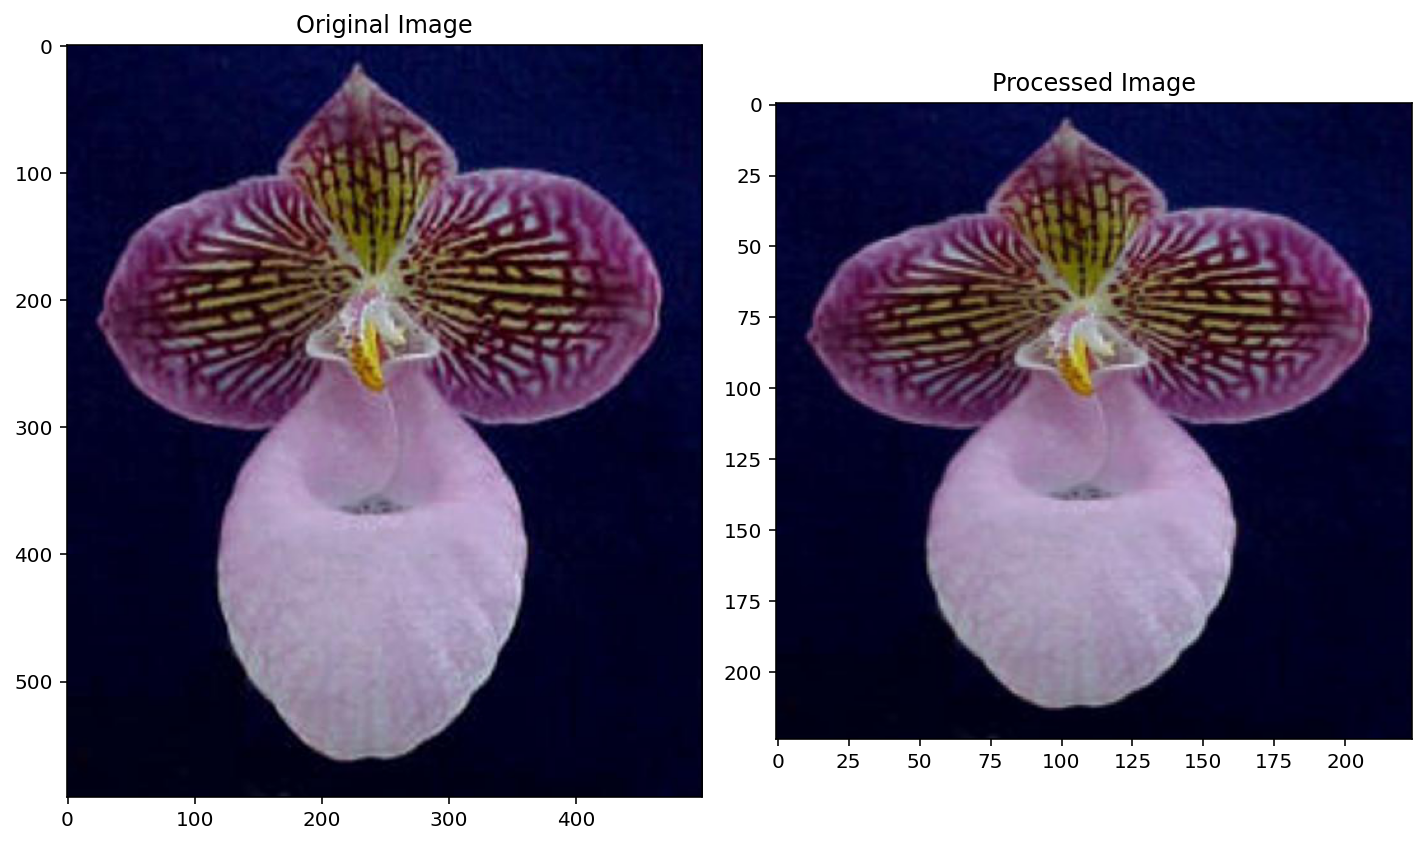

In [ ]:
from PIL import Image
# We modify the original image path to reflect that we are working on Google Colab and accessing our data on Google drive

# image_path = './test_images/hard-leaved_pocket_orchid.jpg'
image_path = '/content/drive/MyDrive/Colab Notebooks/p2_image_classifier/test_images/hard-leaved_pocket_orchid.jpg'
im = Image.open(image_path)
test_image = np.asarray(im)

processed_test_image = process_image(test_image)

fig, (ax1, ax2) = plt.subplots(figsize=(10,10), ncols=2)
ax1.imshow(test_image)
ax1.set_title('Original Image')
ax2.imshow(processed_test_image)
ax2.set_title('Processed Image')
plt.tight_layout()
plt.show()

Once you can get images in the correct format, it's time to write the `predict` function for making inference with your model.

### Inference

Remember, the `predict` function should take an image, a model, and then returns the top $K$ most likely class labels along with the probabilities. The function call should look like: 

```python
probs, classes = predict(image_path, model, top_k)
```

If `top_k=5` the output of the `predict` function should be something like this:

```python
probs, classes = predict(image_path, model, 5)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

Your `predict` function should use `PIL` to load the image from the given `image_path`. You can use the [Image.open](https://pillow.readthedocs.io/en/latest/reference/Image.html#PIL.Image.open) function to load the images. The `Image.open()` function returns an `Image` object. You can convert this `Image` object to a NumPy array by using the `np.asarray()` function.

**Note:** The image returned by the `process_image` function is a NumPy array with shape `(224, 224, 3)` but the model expects the input images to be of shape `(1, 224, 224, 3)`. This extra dimension represents the batch size. We suggest you use the `np.expand_dims()` function to add the extra dimension. 

In [ ]:
# TODO: Create the predict function

def predict(image_path, model, top_k):
    im = Image.open(image_path)
    test_image = np.asarray(im)
    processed_test_image = process_image(test_image)
    redim_img = np.expand_dims(processed_test_image, axis=0)
    pred_prob = model.predict(redim_img)
    pred_prob = pred_prob.tolist()
    probs, classes = tf.math.top_k(pred_prob, top_k)
    probs=probs.numpy().squeeze()
    classes=classes.numpy().squeeze()
    return probs,classes

In [ ]:
top_k = 5
probs, classes = predict(image_path, model, top_k)
print(probs)
print(classes)


[0.878511   0.03481786 0.02600307 0.0143667  0.01074544]
[ 1 76 31 17 96]


# Sanity Check

It's always good to check the predictions made by your model to make sure they are correct. To check your predictions we have provided 4 images in the `./test_images/` folder:

* cautleya_spicata.jpg
* hard-leaved_pocket_orchid.jpg
* orange_dahlia.jpg
* wild_pansy.jpg

In the cell below use `matplotlib` to plot the input image alongside the probabilities for the top 5 classes predicted by your model. Plot the probabilities as a bar graph. The plot should look like this:

<img src='assets/inference_example.png' width=600px>

You can convert from the class integer labels to actual flower names using `class_names`. 

In [ ]:
# TODO: Plot the input image along with the top 5 classes

# First, we obtain all the test image paths
image_paths = glob.glob('/content/drive/MyDrive/Colab Notebooks/p2_image_classifier/test_images/*.jpg')
print(image_paths)

['/content/drive/MyDrive/Colab Notebooks/p2_image_classifier/test_images/orange_dahlia.jpg', '/content/drive/MyDrive/Colab Notebooks/p2_image_classifier/test_images/cautleya_spicata.jpg', '/content/drive/MyDrive/Colab Notebooks/p2_image_classifier/test_images/wild_pansy.jpg', '/content/drive/MyDrive/Colab Notebooks/p2_image_classifier/test_images/hard-leaved_pocket_orchid.jpg']


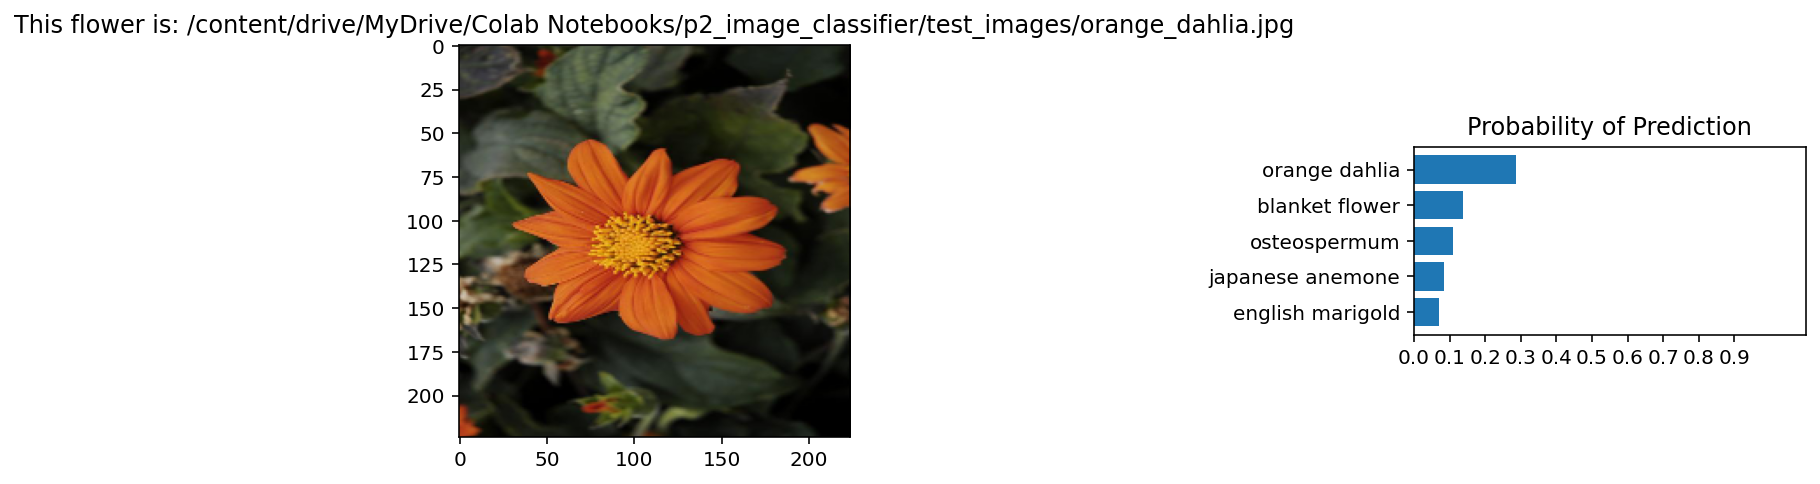

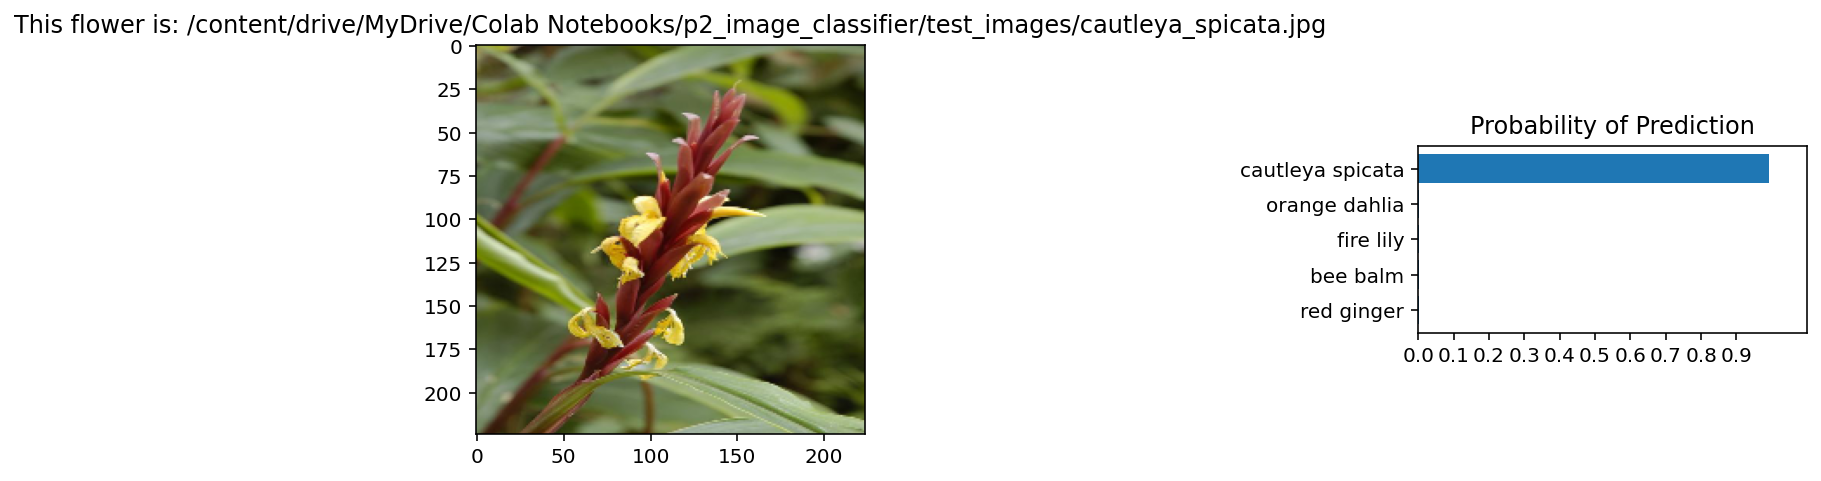

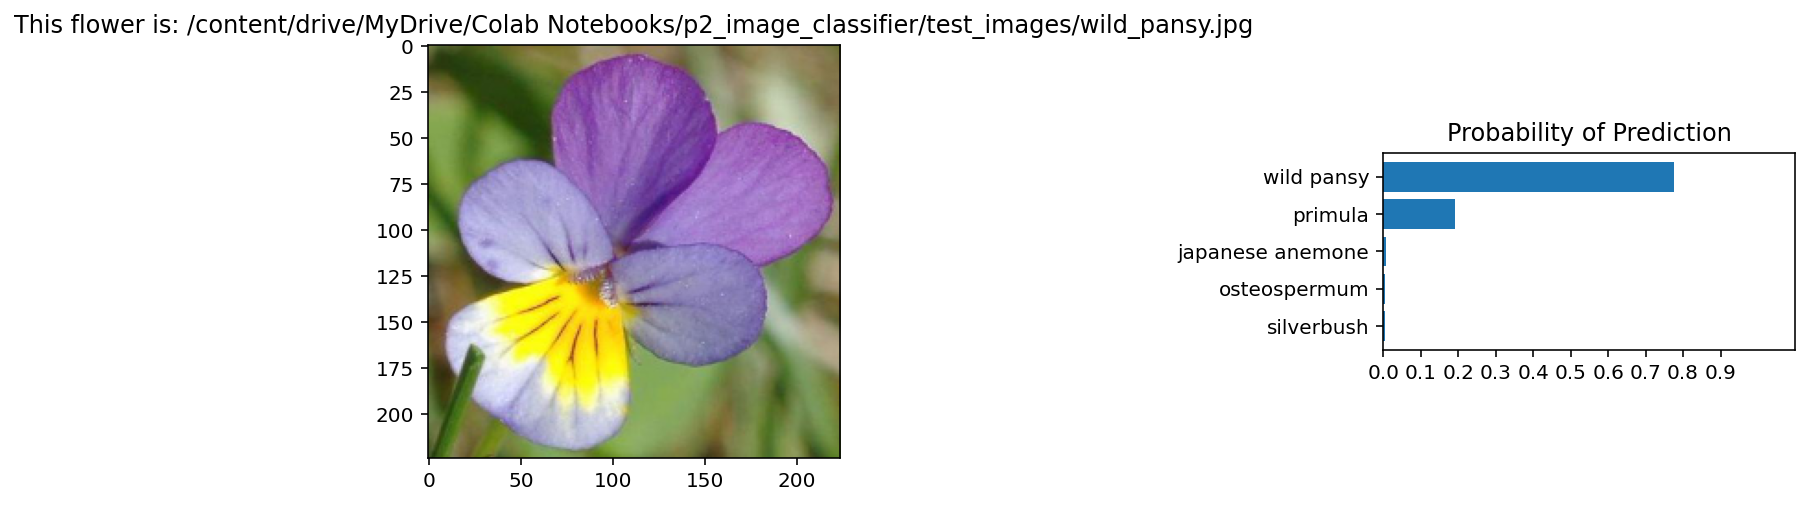

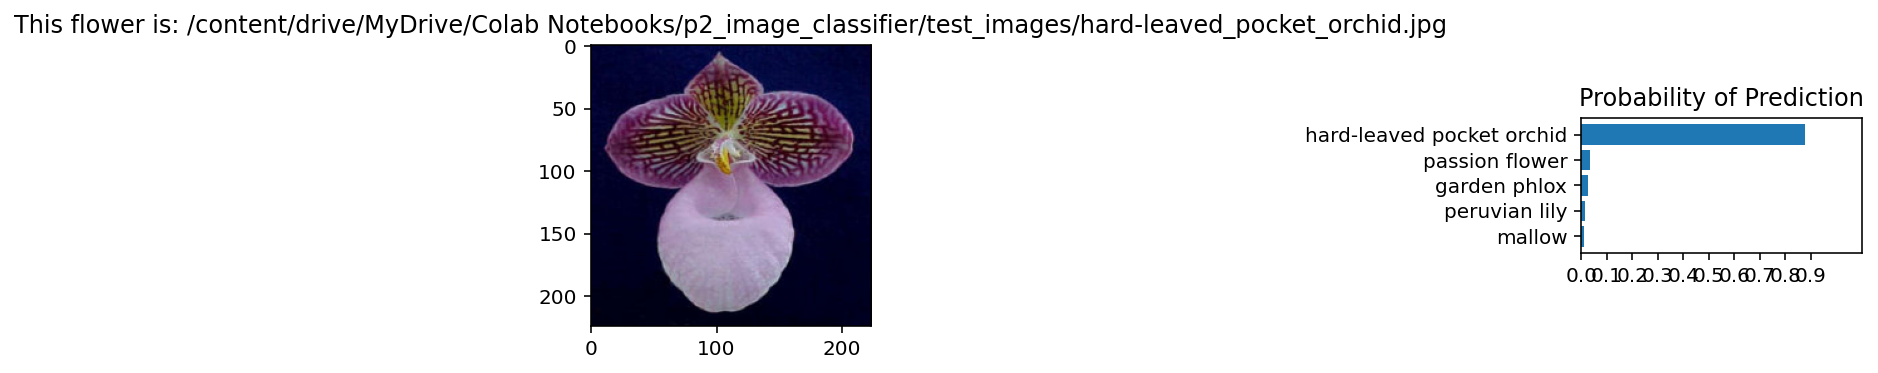

In [ ]:
top_k = 5

for images in image_paths:
    im = Image.open(images)
    test_image = np.asarray(im)
    processed_test_image = process_image(test_image)
    probs, classes = predict(images, reloaded_model, top_k)
    class_label=[str(int(value)+1) for value in classes]
    image_class = [class_names[label] for label in class_label]
    fig, (ax1, ax2) = plt.subplots(figsize=(12,4), ncols=2)
    ax1.imshow(processed_test_image)
    ax1.set_title('This flower is: {}'.format(images))
    ax2.set_title('Probability of Prediction')
    ax2.set_aspect(0.1)
    ax2.set_xlim(0, 1.1)
    ax2.set_xticks(np.arange(10)/10)
    ax2.set_xticklabels(np.arange(10)/10)
    ax2.barh(image_class[::-1], probs[::-1])
    plt.tight_layout()
    plt.show()

In [ ]:
%%shell
jupyter nbconvert --to html ///content/Project_Image_Classifier_Project.ipynb

[NbConvertApp] WARNING | pattern '///content/Project_Image_Classifier_Project.ipynb' matched no files
This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answer yes to any questions instead of prompting.
    Equivalent to: [--JupyterAp

CalledProcessError: ignored